# Create Target Feature

**Summary of the Article**
- Explication of the methodology.
- Import from csv.
- Crate the target feature for min_voltage_bus, max_voltage_bus, and max_current_line.
- Save to csv.

## Methodology
The objective os this master thesis is to predict the occurance and amplitude of constraints violation in the results of the power flow. In order to train, test and evaluate the models it is usefull to transofrm the target output. Since the importante moments are those where the constraints are violated, it is usefull to create a new feature that expresses contains null values for when there is no constraint, and positive value for when there is a constraint. The positive values represent the amplitude of the constraint violation. It can be expressed as follows:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$
In our case, the constraints are being considered as the following:
- Minimal voltage on bus: $v_bus < 0.95 \text{ [pu]}$ (constraint is violated if the voltage is below $0.95 \text{ [pu]} $)
- Maximal voltage on bus: $v_bus > 1.05 \text{ [pu]}$ (constraint is violated if the voltage is above $1.05 \text{ [pu]} $)
- Maximal current on line: $i_line > 1 \text{ [kA]}$ (constraint is violated if the current is above $1 \text{ [kA]} $)

## Import from csv
The results of the Power Flow are stored in a csv file. The csv files were created on the `pandapower_time_series_power_flow.ipynb` notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
res_bus_vm_pu = pd.read_csv('..\data\ground_truth\pf_res_bus_vm_pu.csv')
res_line_i_ka = pd.read_csv('..\data\ground_truth\pf_res_line_i_ka.csv')
res_line_percent = pd.read_csv('..\data\ground_truth\pf_res_line_loading_percent.csv')
timestamps = res_bus_vm_pu['timestamps'].apply(lambda x: pd.to_datetime(x))
res_bus_vm_pu.drop('timestamps', axis=1, inplace=True)
res_line_i_ka.drop('timestamps', axis=1, inplace=True)
res_line_percent.drop('timestamps', axis=1, inplace=True)

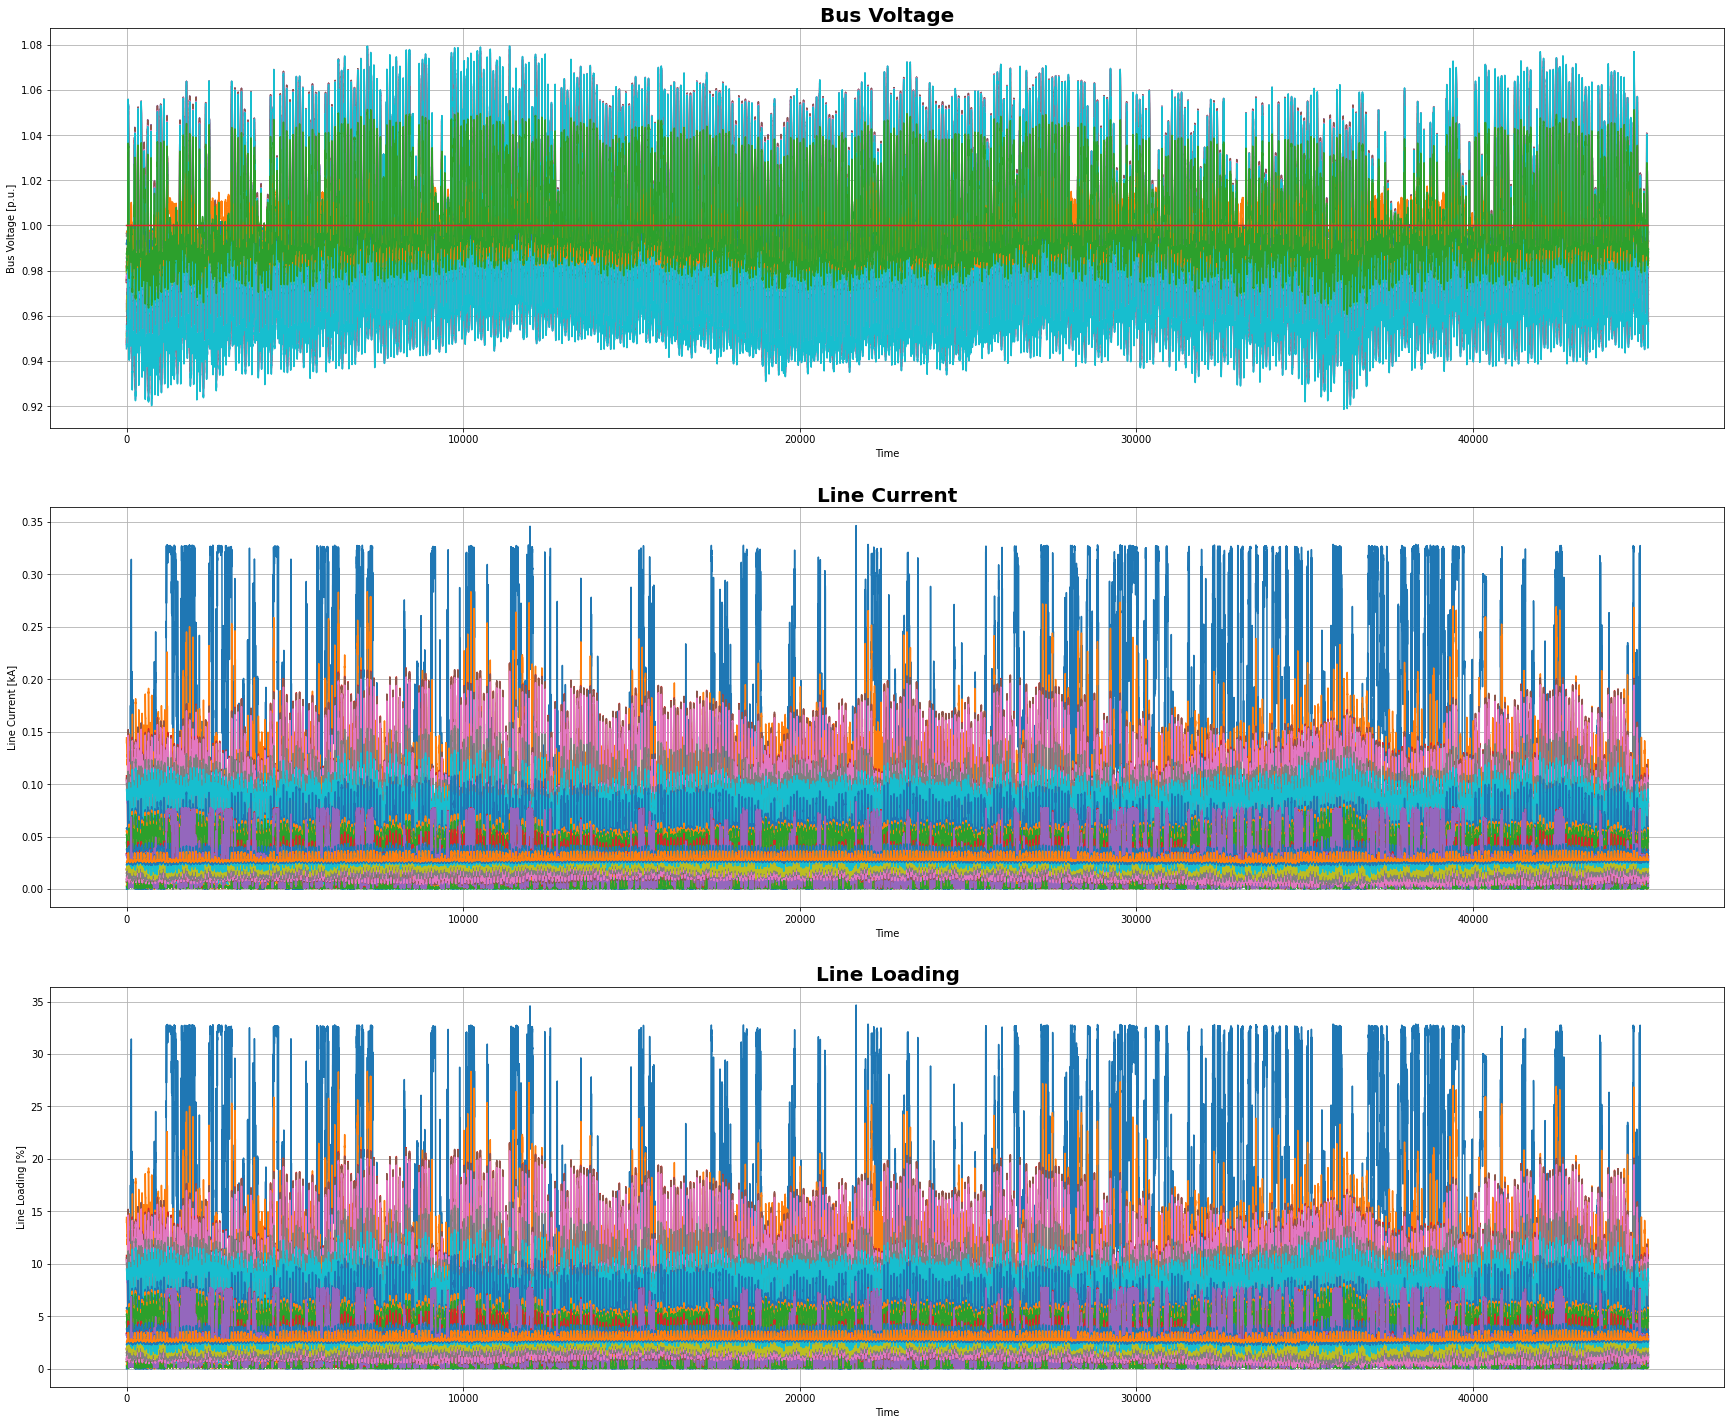

In [2]:
fig, axs = plt.subplots(3, 1, figsize=(30, 25))
# set the x-axis label
axs[0].set_xlabel('Time')
axs[1].set_xlabel('Time')
axs[2].set_xlabel('Time')
# set the y-axis label
axs[0].set_ylabel('Bus Voltage [p.u.]')
axs[1].set_ylabel('Line Current [kA]')
axs[2].set_ylabel('Line Loading [%]')
# set the title, bold and fontsize of the title
axs[0].set_title('Bus Voltage', fontsize=20, fontweight='bold')
axs[1].set_title('Line Current', fontsize=20, fontweight='bold')
axs[2].set_title('Line Loading', fontsize=20, fontweight='bold')
# Set grid
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)
# Data
axs[0].plot(res_bus_vm_pu)
axs[1].plot(res_line_i_ka)
axs[2].plot(res_line_percent)
# Don't print nothing on console
plt.show()


## Create Target Feature
In this section the target features are created using the formula above and stored in a new csv file.

In [3]:
# Min bus_vm_pu constraint
res_bus_vm_pu_min_constr = res_bus_vm_pu.apply(lambda x: (0.95 - x).apply(lambda y: max(0, y)))
# Max bus_vm_pu constraint
res_bus_vm_pu_max_constr = res_bus_vm_pu.apply(lambda x: (x - 1.05).apply(lambda y: max(0, y)))
# Current i_ka constraint.
res_line_i_ka_max_constr = res_line_i_ka.apply(lambda x: (x - 1 ).apply(lambda y: max(0, y)))
# Line loading percent constraint
res_line_percent_constr = res_line_percent.apply(lambda x: (x-100).apply(lambda y: max(0, y)))

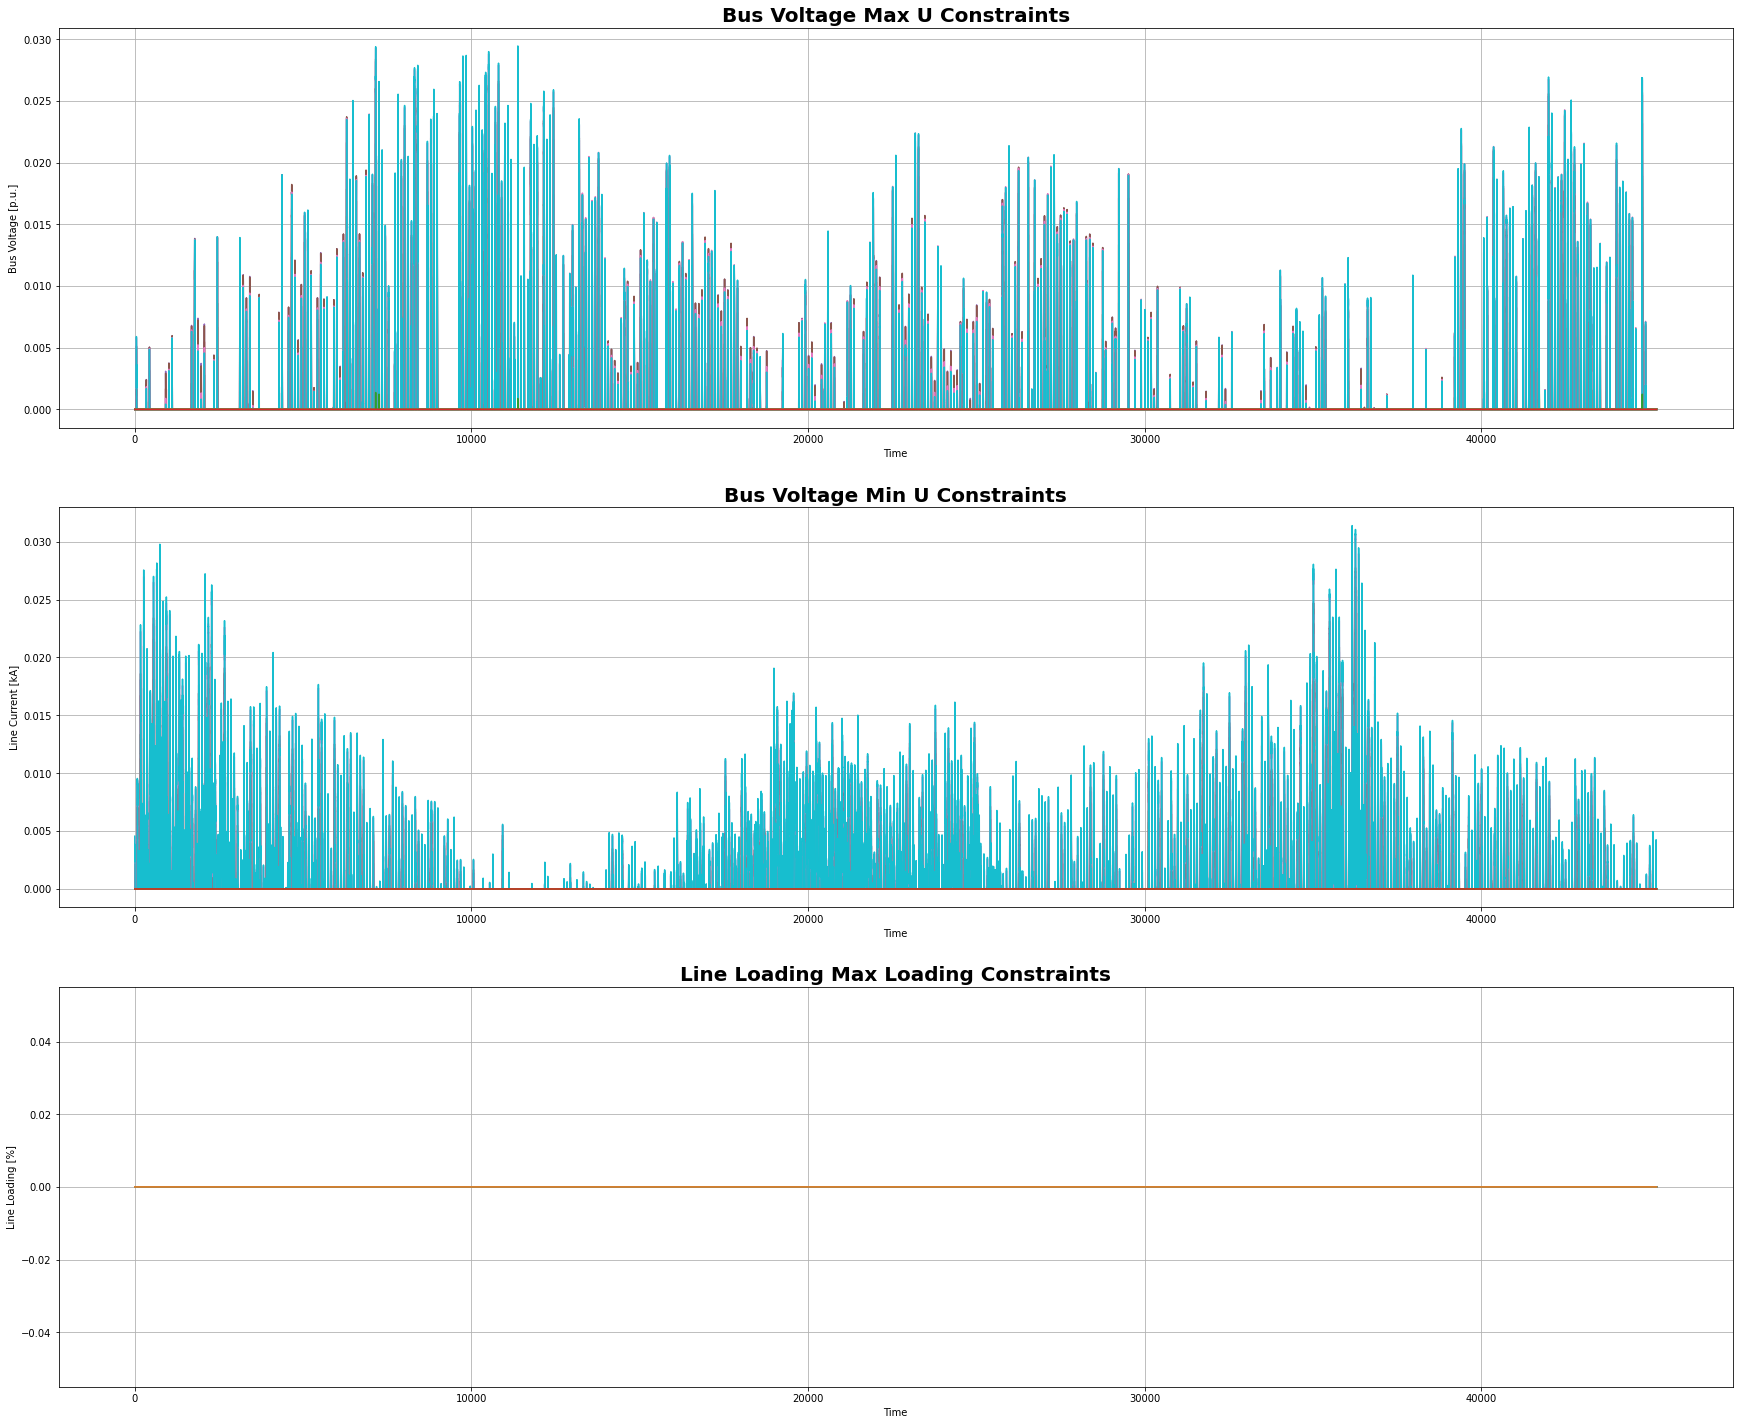

In [4]:
# Plot the three constraints like the plots done above
fig, axs = plt.subplots(3, 1, figsize=(30, 25))
# set the x-axis label
axs[0].set_xlabel('Time')
axs[1].set_xlabel('Time')
axs[2].set_xlabel('Time')
# set the y-axis label
axs[0].set_ylabel('Bus Voltage [p.u.]')
axs[1].set_ylabel('Line Current [kA]')
axs[2].set_ylabel('Line Loading [%]')
# set the title, bold and fontsize of the title
axs[0].set_title('Bus Voltage Max U Constraints', fontsize=20, fontweight='bold')
axs[1].set_title('Bus Voltage Min U Constraints', fontsize=20, fontweight='bold')
axs[2].set_title('Line Loading Max Loading Constraints', fontsize=20, fontweight='bold')
# Set grid
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)
# Data
axs[0].plot(res_bus_vm_pu_max_constr)
axs[1].plot(res_bus_vm_pu_min_constr)
axs[2].plot(res_line_percent_constr)
# Don't print nothing on console
plt.show()

Some visualisations are created to help the user understand the target feature.

## Save to csv
The target features are saved to a csv file.

In [5]:
# Create timestaps feature to the dataframe and save it to csv.
res_bus_vm_pu_min_constr['timestamps'] = timestamps
res_bus_vm_pu_min_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv', index=False)
res_bus_vm_pu_max_constr['timestamps'] = timestamps
res_bus_vm_pu_max_constr.to_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv', index=False)
res_line_i_ka_max_constr['timestamps'] = timestamps
res_line_i_ka_max_constr.to_csv('..\data\ground_truth\\res_line_i_ka_max_constr.csv', index=False)
res_line_percent_constr['timestamps'] = timestamps
res_line_percent_constr.to_csv('..\data\ground_truth\\res_line_percent_max_constr.csv', index=False)